In [1]:
import os
os.chdir('..')
# os.chdir(os.path.dirname(__file__))
print(os.getcwd())

/workspace/rendering


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_specular_reflectance', 'compute_specular_lighting', 'device', 'diffuse_reflectance', 'generic_texture', 'load_state_dict', 'normal_map', 'roughness', 'specular_reflectance', 'state_dict', 'two_sided', 'use_vertex_color']
Scene construction, time: 0.06122 s
Forward pass, time: 0.11370 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


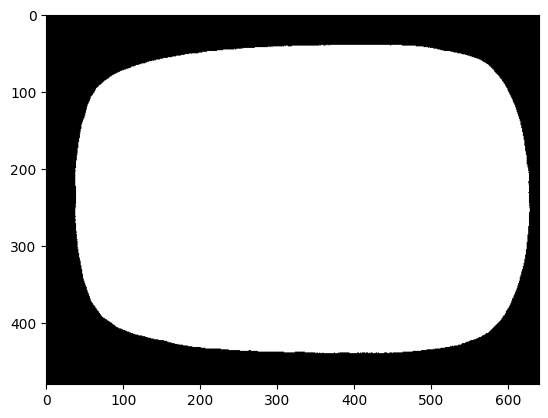

In [2]:
import pyredner # pyredner will be the main Python module we import for redner.
import torch # We also import PyTorch

objects = pyredner.load_obj('data/models/021_bleach_cleanser/textured_simple.obj', return_objects=True)
print(dir(objects[0].material))

camera = pyredner.automatic_camera_placement(objects, resolution=(480, 640))
scene = pyredner.Scene(camera = camera, objects = objects)
light = pyredner.PointLight(
            # position = (camera.position + torch.tensor((0.0, 0.0, 100.0))).to(pyredner.get_device()),
            position = camera.position.to(pyredner.get_device()),
            intensity = torch.tensor((20000.0, 30000.0, 20000.0), 
            device = pyredner.get_device()))
# img = pyredner.render_albedo(scene)
img = pyredner.render_deferred(scene, lights=[light])

# Visualize img
from matplotlib.pyplot import imshow
%matplotlib inline
# Need to gamma compress the image for displaying.
imshow(torch.pow(img, 1.0/2.2).cpu())

In [3]:
# dir(camera)
#  'cam_to_world',
#  'camera_type',
#  'clip_near',
#  'distortion_params',
#  'fov',
#  'intrinsic_mat',
#  'intrinsic_mat_inv',
#  'load_state_dict',
#  'look_at',
#  'position',
#  'resolution',
#  'state_dict',
#  'up',
#  'viewport',
#  'world_to_cam'
# print(camera.world_to_cam)
for k, v in camera.__dict__.items():
    print(k, v)
    print('---')

position tensor([-0.0050,  0.0025, -0.2356])
---
look_at tensor([-0.0050,  0.0025,  0.0133])
---
up tensor([0., 1., 0.])
---
_fov tensor([45.])
---
_cam_to_world None
---
world_to_cam None
---
_intrinsic_mat tensor([[2.4142, 0.0000, 0.0000],
        [0.0000, 2.4142, 0.0000],
        [0.0000, 0.0000, 1.0000]])
---
intrinsic_mat_inv tensor([[0.4142, 0.0000, -0.0000],
        [0.0000, 0.4142, -0.0000],
        [0.0000, 0.0000, 1.0000]])
---
distortion_params None
---
clip_near 0.00012361498177051544
---
resolution (480, 640)
---
viewport None
---
camera_type CameraType.perspective
---


In [4]:
dir(objects[0])
#  'colors',
#  'indices',
#  'light_intensity',
#  'light_two_sided',
#  'material',
#  'normal_indices',
#  'normals',
#  'uv_indices',
#  'uvs',
#  'vertices'

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'colors',
 'indices',
 'light_intensity',
 'light_two_sided',
 'material',
 'normal_indices',
 'normals',
 'uv_indices',
 'uvs',
 'vertices']

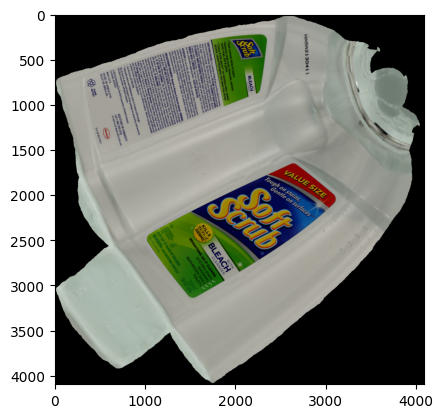

In [5]:
# dir(objects[0].material)
#  'compute_specular_lighting',
#  'device',
#  'diffuse_reflectance',
#  'generic_texture',
#  'load_state_dict',
#  'normal_map',
#  'roughness',
#  'specular_reflectance',
#  'state_dict',
#  'two_sided',
#  'use_vertex_color'
# img = pyredner.render_deferred(scene, lights=[light])
# imshow(torch.pow(img, 1.0/2.2).cpu())
diffuse_texels = objects[0].material.diffuse_reflectance.texels
imshow(diffuse_texels.cpu().numpy())

Scene construction, time: 0.00500 s
Forward pass, time: 0.06720 s


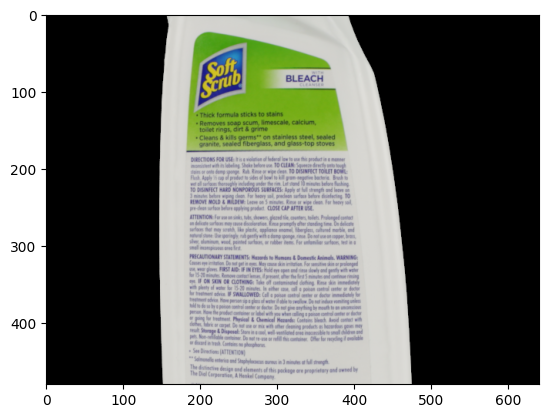

In [6]:
objects = pyredner.load_obj('data/models/021_bleach_cleanser/textured_simple.obj', return_objects=True)
verts = objects[0].vertices.clone()
mat = torch.tensor([
    [1.0, 0, 0],
    [0, 0, 1.0],
    [0, -1.0, 0]
], device=verts.device)

verts = verts @ mat.T

objects[0].vertices = verts

scene = pyredner.Scene(camera = camera, objects = objects)
img = pyredner.render_albedo(scene)
# img = pyredner.render_deferred(scene, lights=[light])

# Visualize img
from matplotlib.pyplot import imshow
%matplotlib inline
# Need to gamma compress the image for displaying.
imshow(torch.pow(img, 1.0/2.2).cpu())

In [7]:
# Obtain the teapot vertices we want to apply the transformation on.
vertices = []
for obj in objects:
    vertices.append(obj.vertices.clone())
# Compute the center of the teapot
center = torch.mean(torch.cat(vertices), 0)
def model(translation, euler_angles):
    # Get the rotation matrix from Euler angles
    rotation_matrix = pyredner.gen_rotate_matrix(euler_angles)
    # Shift the vertices to the center, apply rotation matrix,
    # shift back to the original space, then apply the translation.
    for obj, v in zip(objects, vertices):
        obj.vertices = (v - center) @ torch.t(rotation_matrix) + center + translation
    # Assemble the 3D scene.
    scene = pyredner.Scene(camera = camera, objects = objects)
    # Render the scene.
    img = pyredner.render_albedo(scene)
    return img

target_translation = torch.tensor([0.0, 0.0, 0.0], device = pyredner.get_device())
target_euler_angles = torch.tensor([0.0, 0.0, 0.0], device = pyredner.get_device())
target = model(target_translation, target_euler_angles).data

Scene construction, time: 0.00632 s
Forward pass, time: 0.06499 s


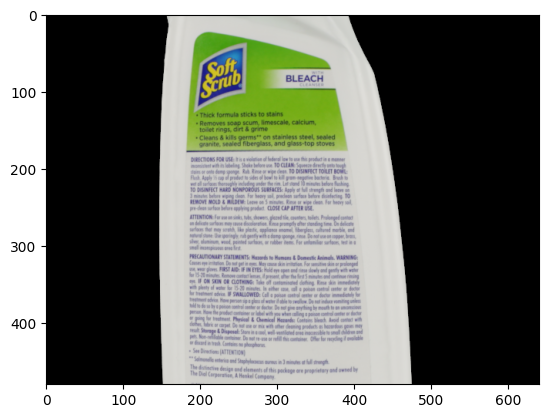

In [8]:
imshow(torch.pow(target, 1.0/2.2).cpu())

# HOデータの読み込み

In [9]:
from utils.utils import load_ho_meta
from utils.mano import ManoLayer

anno = load_ho_meta('data/HO3D_v3/train/ABF10/meta/0000.pkl')
mano = ManoLayer()
mano_verts = mano(anno)

/workspace/rendering/utils/utils.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if v is None or v == 'None':


In [10]:
mano_object = pyredner.Object(
    vertices=mano_verts[0], 
    indices=mano.faces, 
    material=pyredner.Material(
        diffuse_reflectance=pyredner.Texture(mano.map.to(pyredner.get_device()))
        # diffuse_reflectance=torch.tensor((0.5, 0.5, 0.5), device=pyredner.get_device())))
    )
)
print(mano.faces.dtype)

scene = pyredner.Scene(camera = camera, objects = [mano_object])
# Render the scene.
img = pyredner.render_albedo(scene)
    

torch.int32
Scene construction, time: 0.00494 s
Forward pass, time: 0.04371 s


/opt/conda/envs/render-hand/lib/python3.7/site-packages/pyredner/render_pytorch.py:214: UserWarning: Converting shape vertices from cpu to cuda:0, this can be inefficient.
  warnings.warn('Converting shape vertices from {} to {}, this can be inefficient.'.format(shape.vertices.device, device))
/opt/conda/envs/render-hand/lib/python3.7/site-packages/pyredner/render_pytorch.py:216: UserWarning: Converting shape indices from cpu to cuda:0, this can be inefficient.
  warnings.warn('Converting shape indices from {} to {}, this can be inefficient.'.format(shape.indices.device, device))
